# Text Analysis for Central Bank Communication

## Initial steps

In [ ]:
# Initial imports

import numpy as np
import pandas as pd
import gensim
import os
import io
import logging
from matplotlib import pyplot as plt
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
!pip install pyLDAvis

In [ ]:

from google.colab import files
uploaded = files.upload() # use widget to upload your file, remember to enable 3rd party cookies

Saving FOMCtext.csv to FOMCtext.csv


In [ ]:
# Import data
df = pd.read_csv(io.StringIO(uploaded['FOMCtext.csv'].decode('utf-8')))

In [ ]:
df.head()

,Unnamed: 0,Date,Text
0,0,S_19940204.txt,"Release Date: February 4, 1994\n \n\nFor immed..."
1,1,S_19940322.txt,"Release Date: March 22, 1994\n \n\nFor immedia..."
2,2,S_19940517.txt,"Release Date: May 17, 1994\n \n\nFor immediate..."
3,3,S_19940816.txt,"Release Date: August 16, 1994\n \n\nFor immedi..."
4,4,S_19941115.txt,"Release Date: November 15, 1994\n \n\nFor imme..."


This dataframe doesn't look very nice, lets clean it up first

In [ ]:
# Clean up dataframe
df = df.loc[:, ['Date', 'Text']] # only want these columns
df.loc[:, 'PandasDateTime'] = pd.to_datetime(df.loc[:, 'Date'], format='S_%Y%m%d.txt') # create a proper datetime column

In [ ]:
df.head()

,Date,Text,PandasDateTime
0,S_19940204.txt,"Release Date: February 4, 1994\n \n\nFor immed...",1994-02-04
1,S_19940322.txt,"Release Date: March 22, 1994\n \n\nFor immedia...",1994-03-22
2,S_19940517.txt,"Release Date: May 17, 1994\n \n\nFor immediate...",1994-05-17
3,S_19940816.txt,"Release Date: August 16, 1994\n \n\nFor immedi...",1994-08-16
4,S_19941115.txt,"Release Date: November 15, 1994\n \n\nFor imme...",1994-11-15


## Pre-processing text

Text data is often (always?) messy. Lets take a look at the first entry

In [ ]:
df.Text[0]

"Release Date: February 4, 1994\n \n\nFor immediate release\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated with a small increase in short-term money market interest rates.\n\nThe decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion.\n\nChairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee's purposes, given the fact that this is the first firming of reserve market conditions by the Committee since early 1989.\n\n"

What things might we want to strip out of this text to make it less noisy data?

Gensim provides an easy way for us to preprocess the text before we do any analysis on it. Below we define a function that will take in the raw text column from our dataframe, and spit out a set of processed documents. The cell below imports the different options you have for preprocessing the text. You should decide which functions you want to add to your preprocessing function.

Furthermore, you should use the lambda functions to replace specific parts of the text that you want to modify.


In [ ]:
# Import gensim preprocessing functions
from gensim.parsing.preprocessing import preprocess_string # overall function that will allow us to do our preprocessing

#
from gensim.parsing.preprocessing import remove_stopwords # this removes stopwords like 'and' and 'the'
from gensim.parsing.preprocessing import stem_text # this stems text to its root, so economics and econmist both become economi
from gensim.parsing.preprocessing import strip_punctuation # this removes punctuation
from gensim.parsing.preprocessing import strip_short # this removes words shorter than a length the user provides (default 3)
from gensim.parsing.preprocessing import strip_numeric # this removes numbers

In [ ]:
# Define a function that preprocesses the text

def Prep(docseries):
    '''Function that does some preprocessing
    INPUTS: docseries - pandas series, each element is one long string not broken up by tokens
    OUTPUTS: result - list of lists, a list of documents each with a list of token strings'''
    result=[]
    filters = [lambda x: x.lower(),
               lambda x: x.replace('release', ''),
               lambda x: x.replace('date', ''),
               remove_stopwords,
               stem_text,
               strip_punctuation,
               strip_short]
    result = [preprocess_string(document, filters=filters) for document in docseries.tolist()]
    return result

In [ ]:
# Use your function to preprocess the text
df['PreppedText'] = Prep(df.Text)

In [ ]:
# Look at the new dataframe
df.head()

,Date,Text,PandasDateTime,PreppedText
0,S_19940204.txt,"Release Date: February 4, 1994\n \n\nFor immed...",1994-02-04,"[februari, 1994, immedi, chairman, alan, green..."
1,S_19940322.txt,"Release Date: March 22, 1994\n \n\nFor immedia...",1994-03-22,"[march, 1994, immedi, chairman, alan, greenspa..."
2,S_19940517.txt,"Release Date: May 17, 1994\n \n\nFor immediate...",1994-05-17,"[1994, immedi, feder, reserv, todai, announc, ..."
3,S_19940816.txt,"Release Date: August 16, 1994\n \n\nFor immedi...",1994-08-16,"[august, 1994, immedi, feder, reserv, announc,..."
4,S_19941115.txt,"Release Date: November 15, 1994\n \n\nFor imme...",1994-11-15,"[novemb, 1994, immedi, feder, reserv, board, t..."


In [ ]:
# Look at the new processed text
df.PreppedText[0]

['februari',
 '1994',
 'immedi',
 'chairman',
 'alan',
 'greenspan',
 'announc',
 'todai',
 'feder',
 'open',
 'market',
 'committe',
 'decid',
 'increas',
 'slightli',
 'degre',
 'pressur',
 'reserv',
 'positions',
 'action',
 'expect',
 'associ',
 'small',
 'increas',
 'short',
 'term',
 'monei',
 'market',
 'rates',
 'decis',
 'taken',
 'accommod',
 'stanc',
 'monetari',
 'polici',
 'order',
 'sustain',
 'enhanc',
 'econom',
 'expansion',
 'chairman',
 'greenspan',
 'decid',
 'announc',
 'action',
 'immedi',
 'avoid',
 'misunderstand',
 'committee',
 'purposes',
 'given',
 'fact',
 'firm',
 'reserv',
 'market',
 'condit',
 'committe',
 'earli',
 '1989']

## Dictionary methods

We can just count words if we want a measure of what the FOMC is talking about. Try 'alan', 'asset', 'basis' etc etc

In [ ]:
df.loc[:, 'word_count'] = df.loc[:, 'PreppedText'].apply(lambda x: x.count('asset')) # 

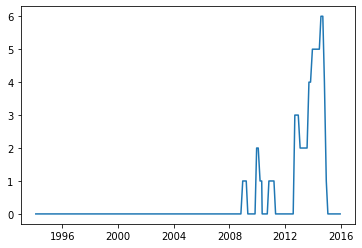

In [ ]:
# Plot results

plt.plot(df.PandasDateTime, df.word_count)
plt.show()

This is probably OK to use now. But we might be able to do better. Want we are trying to do is increase the signal:noise ratio in the text. A lot of what we just did is remove noise. E.g. fullstops are not useful to us, and so keeping them in adds noise to the dataset, so we removed them. 

But now it looks like there are words that are going to be extremely common across all FOMC statements. Words like 'release', if you didn't remove them in preprocessing, occur in every statement. And words like 'monetary' probably occur in nearly all of them. These words aren't going to tell us anything because there is no variation in them between statements. Let's try to remove them.


In [ ]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(df.PreppedText.to_list()) # be clear on what types of objects your function takes

# Filter out words that occur less than 3 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=2, no_above=0.7)

2021-11-22 13:06:14,677 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-22 13:06:14,713 : INFO : built Dictionary(1317 unique tokens: ['1989', '1994', 'accommod', 'action', 'alan']...) from 147 documents (total 31305 corpus positions)
2021-11-22 13:06:14,719 : INFO : discarding 362 tokens: [('1989', 1), ('action', 139), ('avoid', 1), ('chairman', 115), ('committe', 146), ('decid', 123), ('econom', 141), ('expect', 105), ('fact', 1), ('feder', 147)]...
2021-11-22 13:06:14,723 : INFO : keeping 955 tokens which were in no less than 2 and no more than 102 (=70.0%) documents
2021-11-22 13:06:14,726 : INFO : resulting dictionary: Dictionary(955 unique tokens: ['1994', 'accommod', 'alan', 'announc', 'associ']...)


In [ ]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in df.PreppedText.to_list()]

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 955
Number of documents: 147


## LDA

LDA is a generative model. In other words LDA assumes a specific mechanism through which each paragraph is created:

• For each topic (k = 1, 2...K), independently draw a distribution over words ($β_k$) from a Dirichlet($η$)
distribution

• For each paragraph (p = 1, 2...P), independently draw a distribution over topics ($θ_p$) from a
Dirichlet($α$) distribution

• Then for each word in a given paragraph ($w_n$,p):

– Randomly draw a topic ($z_n$,p) from the topic distribution assigned to that paragraph ($θ_p$)

– Randomly draw a word from that topic’s distribution of words ($β_zn$,p)

This process defines a probability distribution over the data that we observe. Then our problem is to compute the posterior distributions of words for each topic ($β_k$ for all k), and the topic distribution for every paragraph ($θ_p$ for all p), given the words we observe.

In [ ]:
# Train LDA model
from gensim.models import LdaModel

# Set training parameters.
num_topics = 5 # number of topics
chunksize = 200 # how many docs to put in RAM
passes = 80 # training epochs
iterations = 800
eval_every = 0

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2021-11-22 13:06:24,485 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2021-11-22 13:06:24,488 : INFO : using serial LDA version on this node
2021-11-22 13:06:24,493 : INFO : running online (multi-pass) LDA training, 5 topics, 80 passes over the supplied corpus of 147 documents, updating model once every 147 documents, evaluating perplexity every 0 documents, iterating 800x with a convergence threshold of 0.001000
2021-11-22 13:06:24,496 : INFO : PROGRESS: pass 0, at document #147/147
2021-11-22 13:06:25,404 : WARNING : updated prior not positive
2021-11-22 13:06:25,406 : INFO : optimized alpha [0.2, 0.2, 0.2, 0.2, 0.2]
2021-11-22 13:06:25,410 : INFO : topic #0 (0.200): 0.014*"labor" + 0.013*"longer" + 0.012*"term" + 0.011*"pace" + 0.011*"secur" + 0.011*"employ" + 0.010*"level" + 0.010*"run" + 0.009*"financi" + 0.009*"like"
2021-11-22 13:06:25,413 : INFO : topic #1 (0.200): 0.020*"board" + 0.014*"reserv" + 0.014*"point" + 0.014*"discount" + 0.013*"approv" + 0.0

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

lda_viz = gensimvis.prepare(model, corpus, dictionary)

2021-11-22 13:06:47,245 : INFO : Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
2021-11-22 13:06:47,277 : INFO : Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
# Do visualisation
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.170673 -0.042733       1        1  33.441523
0      0.193766  0.033442       2        1  31.344293
1     -0.114944  0.163623       3        1  12.753281
4     -0.177919 -0.080631       4        1  12.541053
3     -0.071575 -0.073701       5        1   9.919849, topic_info=         Term        Freq       Total Category  logprob  loglift
40      board  131.000000  131.000000  Default  30.0000  30.0000
22     reserv  130.000000  130.000000  Default  29.0000  29.0000
53   discount   75.000000   75.000000  Default  28.0000  28.0000
37     approv   86.000000   86.000000  Default  27.0000  27.0000
122     moder  129.000000  129.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
248   outlook   18.323082  135.861908   Topic5  -4.8090   0.3072
37     approv   16.632010   86.034352   Topic5  -4.9058   0.6672
51    develop   15.705502   71.674656   Topic5  -4.9631   0.7925
647    promot   15.156069   57.804346   Topic5  -4.9987   0.9720
20    pressur   15.291974  100.159133   Topic5  -4.9898   0.4312

[370 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
284       3  0.933538  2000
353       3  0.915002  2001
417       3  0.914038  2002
484       4  0.910405  2003
539       4  0.912145  2004
...     ...       ...   ...
82        1  0.484880  year
82        2  0.169144  year
82        3  0.112763  year
82        4  0.033829  year
82        5  0.191697  year

[688 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

## Word2Vec

Sometimes we are not so interested in just reducing dimensionality. We might want to find words similar to another word, for example. Tasks like these require us to retain the relationships between words (i.e. we cannot throw that information away by using Bag of Words models).

Neural network architectures for NLP are now common. We will review a famous one, word2vec.

Word2vec (in our case) does two things:
1. Asks a shallow neural network topredict a target word, given the context of the word (i.e. the words in a small window around the target word)
2. After training the network, the weights corresponding to the hidden layer are extracted and used as vector representations of words

In [ ]:
w2vmodel = gensim.models.Word2Vec(df.PreppedText,
                               min_count=2,        # ignore words with frequency less than this
                               window = 5,  # window size around word to predict
                               size=100,    # length of vector # new version: vector_size
                               workers=3,          # number of cores to use
                               iter=10,          # number of times to iterate over the corpus # new version: epochs
                               negative=5)  # negative sub sampling parameter

2021-11-22 13:09:51,469 : INFO : collecting all words and their counts
2021-11-22 13:09:51,472 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-22 13:09:51,486 : INFO : collected 1317 word types from a corpus of 31305 raw words and 147 sentences
2021-11-22 13:09:51,488 : INFO : Loading a fresh vocabulary
2021-11-22 13:09:51,495 : INFO : effective_min_count=2 retains 1007 unique words (76% of original 1317, drops 310)
2021-11-22 13:09:51,497 : INFO : effective_min_count=2 leaves 30995 word corpus (99% of original 31305, drops 310)
2021-11-22 13:09:51,505 : INFO : deleting the raw counts dictionary of 1317 items
2021-11-22 13:09:51,507 : INFO : sample=0.001 downsamples 86 most-common words
2021-11-22 13:09:51,510 : INFO : downsampling leaves estimated 23781 word corpus (76.7% of prior 30995)
2021-11-22 13:09:51,514 : INFO : estimated required memory for 1007 words and 100 dimensions: 1309100 bytes
2021-11-22 13:09:51,519 : INFO : resetting layer weights


In [ ]:
# Does it work?
w2vmodel.wv.most_similar('alan')

2021-11-22 13:09:55,804 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


[('greenspan', 0.9951984882354736),
 ('ben', 0.9858611822128296),
 ('bernanke', 0.9806053638458252),
 ('were', 0.9700348377227783),
 ('timothi', 0.9639649391174316),
 ('mcdonough', 0.9538357853889465),
 ('chair', 0.9538290500640869),
 ('chairman', 0.949632465839386),
 ('william', 0.9465062618255615),
 ('geithner', 0.9385138750076294)]